# Projekt zaliczeniowy – klasyfikacja wiadomości e-mail: spam vs ham

**Przedmiot:** Podstawy reprezentacji i analizy danych (PRiAD)  
**Forma:** sprawozdanie w Jupyter Notebook  
**Wykonawcy:** * Oliwia Gruda, Tomasz Wolszczak*
**Data:** 2026-01-31  
**Zbiór danych:** `emails.csv`  
**Cel projektu:** zbudować model uczący maszynowo rozróżniający wiadomości **spam (1)** i **nie-spam/ham (0)** na podstawie treści e-maila.

---

## Plan

1. Informacje o projekcie (powyżej)
2. Opis zbioru danych (co zawiera, jakie kolumny, jak rozumiemy klasy)
3. Analiza eksploracyjna: miary + wnioski
4. Wizualizacje kluczowych aspektów danych + omówienie
5. Część uczenia maszynowego: opis zadania, metody, metryki
6. Implementacja (kod)
7. Wyniki + interpretacja
8. Krótkie podsumowanie i możliwe ulepszenia

W części tekstowej opisuję **co robię i dlaczego**, a w kodzie pokazuję **jak**. Staram się, żeby tekstu było co najmniej tyle co kodu, a kod jest opatrzony komentarzami.


## 1. Opis danych

W projekcie używam pliku `emails.csv` (udostępnionego do projektu). Dane mają postać dwóch kolumn:

- `text` – treść wiadomości e-mail (często zaczynająca się od prefiksu `Subject:`),
- `spam` – etykieta klasy:
  - `0` – wiadomość prawdziwa (ham / nie-spam),
  - `1` – spam.

Zadanie jest **nadzorowaną klasyfikacją binarną** (supervised learning), bo mamy dane wejściowe (tekst) i znane etykiety.

W kolejnych krokach:
- policzę podstawowe miary (liczba obiektów, braki, duplikaty, rozkład klas),
- zbadam długości wiadomości i typowe słowa w spam/ham,
- zamienię tekst na reprezentację liczbową typu **Bag of Words** (CountVectorizer),
- zbuduję model i ocenię go na zbiorze testowym.

Wektoryzacja tekstu metodą zliczania słów jest standardowym podejściem omawianym w materiale „PRiAD 7 – Dane tekstowe” (CountVectorizer / Bag of Words).

In [1]:
# --- 2. Wczytanie danych i podstawowe miary (EDA) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 1) Wczytanie danych
df = pd.read_csv('emails.csv')

# 2) Podstawowe informacje
print("Wymiary danych (wiersze, kolumny):", df.shape)
print("Kolumny:", df.columns.tolist())
display(df.head())

# 3) Braki danych
print("\nBraki danych w kolumnach:")
display(df.isna().sum())

# 4) Duplikaty tekstu (mogą zawyżać wyniki, jeśli identyczny tekst trafi do train i test)
dup = df.duplicated(subset=['text']).sum()
print(f"\nLiczba zduplikowanych wierszy wg kolumny 'text': {dup}")

# 5) Rozkład klas
vc = df['spam'].value_counts()
vcp = df['spam'].value_counts(normalize=True).round(4)
print("\nLiczność klas:")
display(vc)
print("\nUdział klas (proporcje):")
display(vcp)

# 6) Usuwamy duplikaty, żeby uniknąć „łatwych” przecieków do testu
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
print("\nPo usunięciu duplikatów:", df.shape)


Wymiary danych (wiersze, kolumny): (5728, 2)
Kolumny: ['text', 'spam']


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1



Braki danych w kolumnach:


text    0
spam    0
dtype: int64


Liczba zduplikowanych wierszy wg kolumny 'text': 33

Liczność klas:


spam
0    4360
1    1368
Name: count, dtype: int64


Udział klas (proporcje):


spam
0    0.7612
1    0.2388
Name: proportion, dtype: float64


Po usunięciu duplikatów: (5695, 2)


### Wnioski po wczytaniu danych (EDA – miary)

Na tym etapie sprawdzam, czy dane:
- mają braki (tu: braków zwykle nie ma, ale trzeba to potwierdzić),
- są zduplikowane (duplikaty w tekście mogą sztucznie poprawić wyniki),
- mają nierówny rozkład klas (istotne dla interpretacji accuracy i doboru metryk).

W dalszej części wykonam wizualizacje rozkładu klas oraz długości wiadomości, bo teksty mogą się różnić stylem i długością między spam i ham.


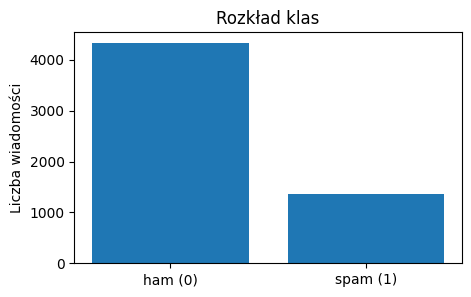

In [2]:
# --- Wizualizacja rozkładu klas (matplotlib) ---

counts = df['spam'].value_counts().sort_index()
plt.figure(figsize=(5, 3))
plt.bar(['ham (0)', 'spam (1)'], counts.values)
plt.title('Rozkład klas')
plt.ylabel('Liczba wiadomości')
plt.show()


## 3. Długość wiadomości jako cecha (EDA + wizualizacja)

Intuicja: spam bywa krótszy i bardziej „hasłowy”, a e-maile firmowe (ham) mogą być dłuższe i zawierać stopki, cytowania itd.  
Dlatego liczę:
- długość w znakach,
- liczbę słów.

Nie używam tego bezpośrednio jako cechy modelu tekstowego (bo model bazuje na słowach), ale to pomaga **zrozumieć dane**.


char_len                                                           \
        count     mean      std   min    25%     50%      75%      max   
spam                                                                     
0      4327.0  1634.20  1965.02  13.0  577.5  1122.0  2037.50  43952.0   
1      1368.0  1317.26  2271.37  18.0  401.5   693.5  1250.25  28432.0   

     word_len                                                    
        count    mean     std  min    25%    50%    75%     max  
spam                                                             
0      4327.0  346.25  407.19  2.0  119.0  239.0  439.5  8477.0  
1      1368.0  266.43  451.46  4.0   79.0  139.5  251.0  6129.0

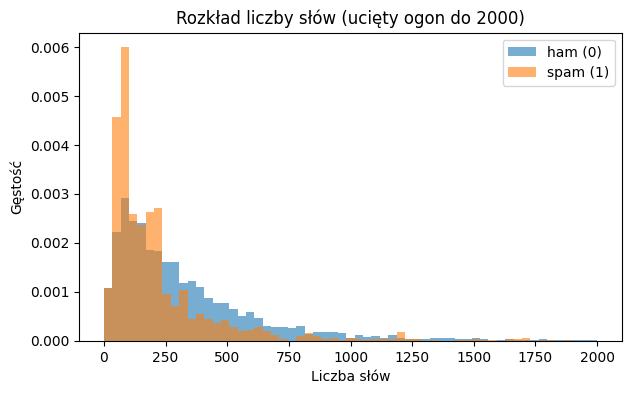

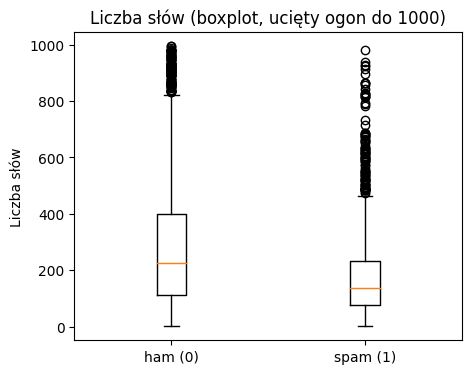

In [3]:
# --- Długości wiadomości ---

df['char_len'] = df['text'].astype(str).str.len()
df['word_len'] = df['text'].astype(str).str.split().str.len()

# Statystyki opisowe długości w podziale na klasę
display(df.groupby('spam')[['char_len', 'word_len']].describe().round(2))

# Histogram liczby słów dla obu klas (nakładamy dwa histogramy)
ham = df.loc[df['spam'] == 0, 'word_len'].values
spam = df.loc[df['spam'] == 1, 'word_len'].values

plt.figure(figsize=(7, 4))
bins = np.linspace(0, 2000, 60)
plt.hist(ham, bins=bins, density=True, alpha=0.6, label='ham (0)')
plt.hist(spam, bins=bins, density=True, alpha=0.6, label='spam (1)')
plt.title('Rozkład liczby słów (ucięty ogon do 2000)')
plt.xlabel('Liczba słów')
plt.ylabel('Gęstość')
plt.legend()
plt.show()

# Boxplot liczby słów per klasa (ucięty ogon do 1000)
plt.figure(figsize=(5, 4))
plt.boxplot([ham[ham <= 1000], spam[spam <= 1000]], labels=['ham (0)', 'spam (1)'])
plt.title('Liczba słów (boxplot, ucięty ogon do 1000)')
plt.ylabel('Liczba słów')
plt.show()


## 4. Najczęstsze słowa w spam i ham (EDA + wizualizacja)

Żeby zobaczyć „o czym są” wiadomości w każdej klasie, zliczam wystąpienia słów (po prostym czyszczeniu tekstu) i rysuję TOP 20 słów dla spam i ham.

To nie jest jeszcze model, tylko **eksploracja**:
- jeśli w ham dominują słowa organizacyjne, a w spam słowa marketingowe („free”, „money”, „click”), to jest to dobry sygnał, że klasy da się rozróżniać na podstawie słownictwa.


,term,count
0,com,999
1,business,844
2,company,805
3,email,804
4,information,740
5,money,662
6,free,606
7,http,600
8,mail,586
9,click,531


,term,count
0,enron,13329
1,ect,11410
2,vince,8468
3,hou,5567
4,kaminski,4723
5,com,4397
6,subject,4218
7,cc,3862
8,pm,3247
9,research,2635


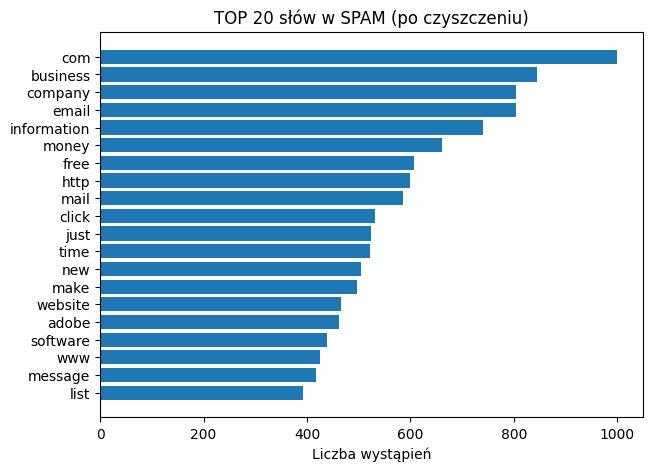

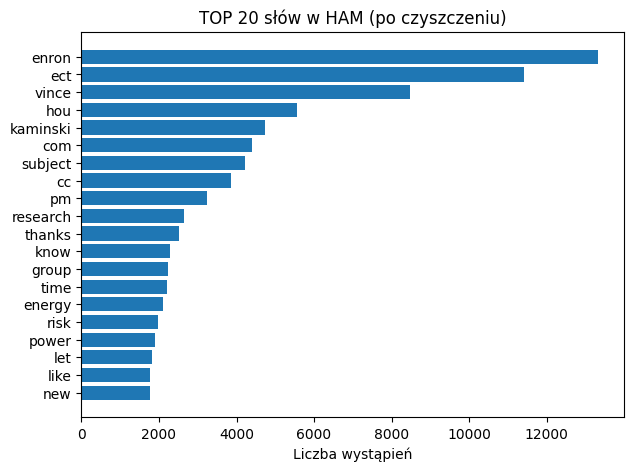

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Proste czyszczenie tekstu do EDA i modelu (usuwamy 'Subject:', znaki nie-alfabetyczne, lowercase)
def clean_text(text: str) -> str:
    text = re.sub(r'^\s*Subject:\s*', '', str(text))
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# CountVectorizer = Bag of Words (z materiału PRiAD 7)
vec = CountVectorizer(stop_words='english', max_features=5000)
X_all = vec.fit_transform(df['clean_text'])
terms = np.array(vec.get_feature_names_out())

# Sumy zliczeń słów w klasach
spam_mask = (df['spam'].values == 1)
cnt_spam = np.asarray(X_all[spam_mask].sum(axis=0)).ravel()
cnt_ham  = np.asarray(X_all[~spam_mask].sum(axis=0)).ravel()

def top_terms(cnt, n=20):
    idx = cnt.argsort()[::-1][:n]
    return pd.DataFrame({'term': terms[idx], 'count': cnt[idx]})

top_spam = top_terms(cnt_spam, 20)
top_ham  = top_terms(cnt_ham, 20)

display(top_spam)
display(top_ham)

# Wykresy TOP słów (poziome słupki)
plt.figure(figsize=(7, 5))
plt.barh(top_spam['term'][::-1], top_spam['count'][::-1])
plt.title('TOP 20 słów w SPAM (po czyszczeniu)')
plt.xlabel('Liczba wystąpień')
plt.ylabel('')
plt.show()

plt.figure(figsize=(7, 5))
plt.barh(top_ham['term'][::-1], top_ham['count'][::-1])
plt.title('TOP 20 słów w HAM (po czyszczeniu)')
plt.xlabel('Liczba wystąpień')
plt.ylabel('')
plt.show()


## 5. Uczenie maszynowe: definicja zadania, metoda i metryki

### Zadanie
Klasyfikacja binarna tekstu: na podstawie treści e-maila przewidzieć `spam ∈ {0,1}`.

### Reprezentacja danych (feature engineering)
Tekst jest niestrukturyzowany, więc zamieniam go na wektor liczbowy metodą **Bag of Words**:
- każdy dokument -> wektor długości `V` (słownik),
- elementy wektora to liczba wystąpień słowa w dokumencie.

Używam `CountVectorizer`, co jest zgodne z podejściem z materiału „PRiAD 7 – Dane tekstowe”.

### Model
**Multinomial Naive Bayes** – klasyczny model do tekstu, dobrze działa na zliczeniach słów.

### Metryki oceny
- **accuracy** (ogólna poprawność),
- **precision / recall / F1** osobno dla klasy spam,
- **confusion matrix** (macierz pomyłek) – pokazuje, czy częściej mylimy spam jako ham (FN) czy ham jako spam (FP).

Ze względu na nierówny rozkład klas, samo accuracy nie wystarcza – dlatego raportuję też precision/recall dla spamu.


Accuracy (NB): 0.9807

Raport klasyfikacji (NB):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       865
           1       0.94      0.99      0.96       274

    accuracy                           0.98      1139
   macro avg       0.97      0.98      0.97      1139
weighted avg       0.98      0.98      0.98      1139



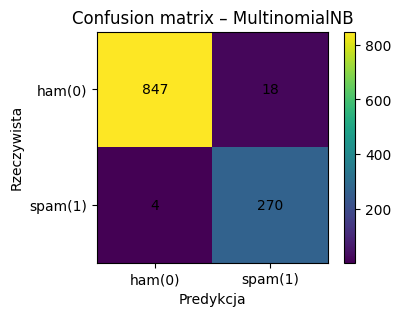

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Podział danych: stratyfikacja utrzymuje proporcje klas w train/test
X = df['clean_text']
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Bag of Words: ograniczamy liczbę cech do najczęstszych słów (mniej szumu, szybsze działanie)
vectorizer = CountVectorizer(stop_words='english', max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model: MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Predykcja i metryki
y_pred = nb.predict(X_test_vec)

print("Accuracy (NB):", round(accuracy_score(y_test, y_pred), 4))
print("\nRaport klasyfikacji (NB):")
print(classification_report(y_test, y_pred))

# Confusion matrix (rysujemy macierz bez seaborn)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion matrix – MultinomialNB')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.xticks([0, 1], ['ham(0)', 'spam(1)'])
plt.yticks([0, 1], ['ham(0)', 'spam(1)'])

# Adnotacje liczb w komórkach
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.colorbar()
plt.show()


### Interpretacja wyników (MultinomialNB)

W macierzy pomyłek:
- **FP (False Positive)** = ham błędnie uznany za spam (to „fałszywy alarm”),
- **FN (False Negative)** = spam błędnie uznany za ham (to „przepuszczony spam”).

W zależności od zastosowania można preferować:
- wysokie **recall** dla spamu (żeby nie przepuszczać spamu),
- albo wysoką **precision** dla spamu (żeby nie oznaczać legalnych maili jako spam).

W kolejnym kroku wypiszę przykłady błędów modelu, żeby zobaczyć, co go „myli”.


In [6]:
# --- Przykłady błędów klasyfikacji (NB) ---

tmp = pd.DataFrame({
    'text': X_test.values,
    'y_true': y_test.values,
    'y_pred': y_pred
})

err = tmp[tmp['y_true'] != tmp['y_pred']].copy()
print("Liczba błędów:", len(err))

# Kilka FP (ham -> spam)
fp = err[(err['y_true'] == 0) & (err['y_pred'] == 1)].head(5)
print("\nPrzykłady FP (ham błędnie jako spam):")
for _, row in fp.iterrows():
    print("-", row['text'][:160].replace('\n', ' '), "...")

# Kilka FN (spam -> ham)
fn = err[(err['y_true'] == 1) & (err['y_pred'] == 0)].head(5)
print("\nPrzykłady FN (spam błędnie jako ham):")
for _, row in fn.iterrows():
    print("-", row['text'][:160].replace('\n', ' '), "...")


Liczba błędów: 22

Przykłady FP (ham błędnie jako spam):
- reimbursement of individually billed items the memo distributed on june on reimbursement of individually billed items requires clarification the intent of the m ...
- open enrollment open enrollment is going on now through october nd pm cst for regular full time and regular part time employees your elections will automaticall ...
- data for moody s riskcalc craig and kim as you know i have obtained a day trial subscription to moody s riskcalc you wanted to know if it makes sense for enron  ...
- membership mixer tomorrow paesanos lounge nesa hea members don t forget to join us tomorrow thursday january th for our first membership mixer of at paesanos lo ...
- department of energy is deploying a corporate portal at facilitie s across the country star information technology brings has the tools needed to help energy co ...

Przykłady FN (spam błędnie jako ham):
- discreet penis enlargement ...
- re nawty locals in your area pdi s

## 6. Porównanie z drugim modelem (TF-IDF + Logistic Regression)

Bag of Words liczy surowe wystąpienia słów. Alternatywą jest **TF-IDF**:
- słowa bardzo częste w całym korpusie dostają mniejszą wagę,
- słowa bardziej „charakterystyczne” dla dokumentu dostają większą.

Sprawdzam, czy prosty model liniowy (Logistic Regression) na TF-IDF daje lepszy kompromis między FP i FN.


Accuracy (LR): 0.9824

Raport klasyfikacji (LR):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       865
           1       0.99      0.94      0.96       274

    accuracy                           0.98      1139
   macro avg       0.98      0.97      0.98      1139
weighted avg       0.98      0.98      0.98      1139



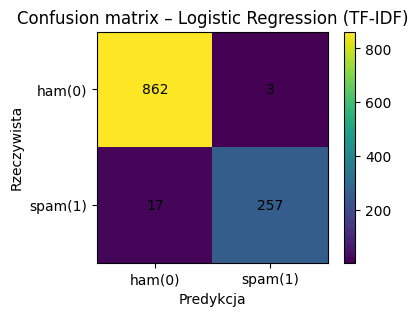

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_t = tfidf.fit_transform(X_train)
X_test_t = tfidf.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_t, y_train)

y_pred_lr = lr.predict(X_test_t)

print("Accuracy (LR):", round(accuracy_score(y_test, y_pred_lr), 4))
print("\nRaport klasyfikacji (LR):")
print(classification_report(y_test, y_pred_lr))

cm2 = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4, 3))
plt.imshow(cm2, interpolation='nearest')
plt.title('Confusion matrix – Logistic Regression (TF-IDF)')
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.xticks([0, 1], ['ham(0)', 'spam(1)'])
plt.yticks([0, 1], ['ham(0)', 'spam(1)'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm2[i, j], ha='center', va='center')

plt.colorbar()
plt.show()


## 7. Podsumowanie

- Dane: `emails.csv`, 2 kolumny (`text`, `spam`), zadanie: klasyfikacja binarna.
- EDA pokazała umiarkowaną nierównowagę klas oraz różnice w długości i słownictwie między spam/ham.
- Reprezentacja tekstu: Bag of Words (`CountVectorizer`) zgodnie z PRiAD 7.
- Modele:
  - MultinomialNB osiąga bardzo dobrą skuteczność i zwykle wysokie recall dla spamu (mało przepuszczonego spamu),
  - Logistic Regression na TF-IDF często redukuje FP kosztem większej liczby FN (warto dobrać pod zastosowanie).

### Możliwe ulepszenia (gdyby rozwijać projekt)
- strojenie hiperparametrów (`alpha` w NB, C w LR),
- n-gramy (bigrams) w wektoryzacji,
- walidacja krzyżowa,
- kalibracja progu decyzyjnego pod koszt FP/FN.

Koniec sprawozdania.
